In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier, plot_importance
import joblib
import warnings
warnings.filterwarnings('ignore')

In [103]:
df = pd.read_csv("parkinsons.csv")


In [104]:
df.head()

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


In [105]:
# Exploratory data analysis
print("Dataset shape:", df.shape)
print("\nClass distribution:\n", df["status"].value_counts())
print("\nClass proportions:\n", df["status"].value_counts(normalize=True))

Dataset shape: (195, 24)

Class distribution:
 status
1    147
0     48
Name: count, dtype: int64

Class proportions:
 status
1    0.753846
0    0.246154
Name: proportion, dtype: float64


In [106]:
X = df.drop(columns=["name", "status"], axis=1)
Y = df["status"]

In [107]:
print("\nFeatures summary:")
print(X.describe().transpose()[['mean', 'std', 'min', 'max']])


Features summary:
                        mean        std         min         max
MDVP:Fo(Hz)       154.228641  41.390065   88.333000  260.105000
MDVP:Fhi(Hz)      197.104918  91.491548  102.145000  592.030000
MDVP:Flo(Hz)      116.324631  43.521413   65.476000  239.170000
MDVP:Jitter(%)      0.006220   0.004848    0.001680    0.033160
MDVP:Jitter(Abs)    0.000044   0.000035    0.000007    0.000260
MDVP:RAP            0.003306   0.002968    0.000680    0.021440
MDVP:PPQ            0.003446   0.002759    0.000920    0.019580
Jitter:DDP          0.009920   0.008903    0.002040    0.064330
MDVP:Shimmer        0.029709   0.018857    0.009540    0.119080
MDVP:Shimmer(dB)    0.282251   0.194877    0.085000    1.302000
Shimmer:APQ3        0.015664   0.010153    0.004550    0.056470
Shimmer:APQ5        0.017878   0.012024    0.005700    0.079400
MDVP:APQ            0.024081   0.016947    0.007190    0.137780
Shimmer:DDA         0.046993   0.030459    0.013640    0.169420
NHR                 0

In [108]:
# Handle class imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(Y), y=Y)
weight_ratio = class_weights[1] / class_weights[0]  # scale_pos_weight for XGBoost
print(f"\nClass weight ratio (Parkinson's/Healthy): {weight_ratio:.2f}")


Class weight ratio (Parkinson's/Healthy): 0.33


In [109]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("\nScaler mean:", scaler.mean_[:5], "...")  # First 5 means


Scaler mean: [1.54228641e+02 1.97104918e+02 1.16324631e+02 6.22046154e-03
 4.39589744e-05] ...


In [110]:
sample_check = X_scaled[0]
print(f"Sample scaling check (first 5 features): {sample_check[:5]}")
print(f"Sample scaling variance check: {np.var(sample_check):.2f}")

Sample scaling check (first 5 features): [-0.82929965 -0.43616456 -0.95203729  0.33491386  0.74975946]
Sample scaling variance check: 0.44


In [111]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X_scaled, Y, test_size=0.2, random_state=42, stratify=Y
)
print(f"\nTraining set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")



Training set size: 156, Test set size: 39


In [112]:
# Hyperparameter tuning with class weights
params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [2, 3, 4],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 0.9],
    'scale_pos_weight': [weight_ratio]  # Handle imbalance
}

# Initialize XGBoost classifier
xgb = XGBClassifier(scale_pos_weight=weight_ratio, eval_metric='logloss')

# Grid search setup
grid = GridSearchCV(
    xgb, params, cv=5,
    scoring='balanced_accuracy',  # Changed from accuracy to balanced_accuracy
    verbose=1, n_jobs=-1
)


In [113]:
print("\nStarting grid search...")
grid.fit(X_train, Y_train)
best_model = grid.best_estimator_


Starting grid search...
Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [114]:
# Save model and scaler
joblib.dump(best_model, 'parkinsons_xgb_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [115]:
# Cross-validation with stratified k-fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_model, X_scaled, Y, cv=skf, scoring='balanced_accuracy')
print(f"\nCross-Validation Balanced Accuracy: {np.mean(cv_scores):.2f} ± {np.std(cv_scores):.2f}")
print("\nBest Parameters:", grid.best_params_)


Cross-Validation Balanced Accuracy: 0.89 ± 0.06

Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'scale_pos_weight': np.float64(0.32653061224489793), 'subsample': 0.8}


In [116]:
train_preds = best_model.predict(X_train)
test_preds = best_model.predict(X_test)
test_probs = best_model.predict_proba(X_test)[:, 1]


In [117]:
# Calculate and report metrics
print("\nTraining Accuracy:", accuracy_score(Y_train, train_preds))
print("Test Accuracy:", accuracy_score(Y_test, test_preds))

# Classification report
print("\nClassification Report:\n", classification_report(Y_test, test_preds))


Training Accuracy: 1.0
Test Accuracy: 0.9487179487179487

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.97      0.97      0.97        29

    accuracy                           0.95        39
   macro avg       0.93      0.93      0.93        39
weighted avg       0.95      0.95      0.95        39



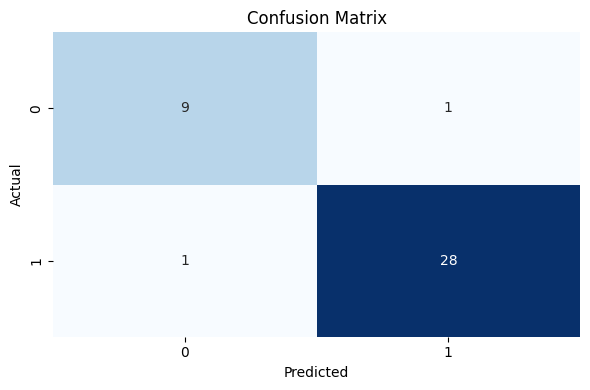

In [118]:
# Confusion matrix
cm = confusion_matrix(Y_test, test_preds)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

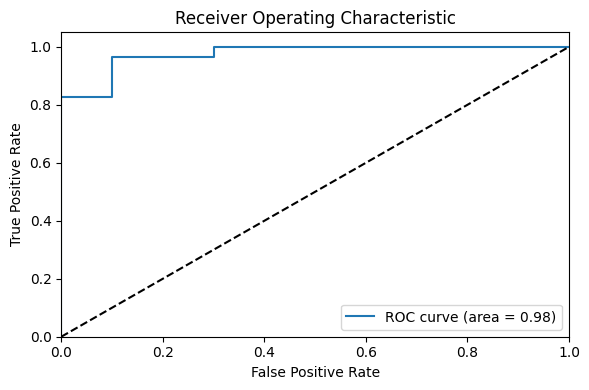

In [119]:
# ROC curve analysis
fpr, tpr, _ = roc_curve(Y_test, test_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig('roc_curve.png')
plt.show()

In [120]:
# Precision-Recall curve and optimal threshold
precisions, recalls, thresholds = precision_recall_curve(Y_test, test_probs)
f1_scores = np.nan_to_num(2 * (precisions * recalls) / (precisions + recalls))
optimal_idx = np.argmax(f1_scores[:-1])  # Last element doesn't have threshold
optimal_threshold = thresholds[optimal_idx]

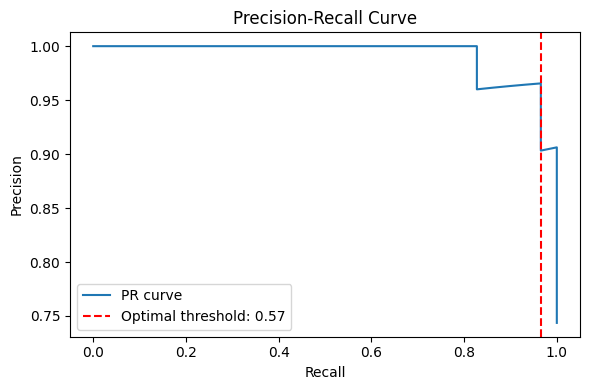


Optimal threshold from PR curve: 0.57


In [121]:
plt.figure(figsize=(6,4))
plt.plot(recalls, precisions, label=f'PR curve')
plt.axvline(x=recalls[optimal_idx], color='r', linestyle='--',
           label=f'Optimal threshold: {optimal_threshold:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.tight_layout()
plt.savefig('pr_curve.png')
plt.show()

print(f"\nOptimal threshold from PR curve: {optimal_threshold:.2f}")



Adjusted Classification Report (with optimal threshold):
               precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.97      0.97      0.97        29

    accuracy                           0.95        39
   macro avg       0.93      0.93      0.93        39
weighted avg       0.95      0.95      0.95        39



<Figure size 1000x600 with 0 Axes>

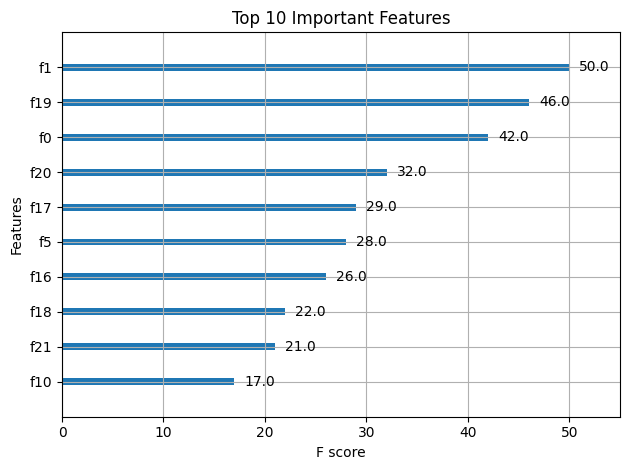

In [122]:
# Recalculate predictions with optimal threshold
adjusted_preds = (test_probs >= optimal_threshold).astype(int)
print("\nAdjusted Classification Report (with optimal threshold):\n",
      classification_report(Y_test, adjusted_preds))

# Feature importance
plt.figure(figsize=(10,6))
plot_importance(best_model, max_num_features=10, importance_type='weight')
plt.title("Top 10 Important Features")
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.show()

In [123]:
from sklearn.utils import resample

# Step 1: Combine X and Y first (after scaling)
full_scaled = pd.concat([pd.DataFrame(X_scaled, columns=X.columns), Y.reset_index(drop=True)], axis=1)

# Step 2: Separate into class 0 and 1
class_0 = full_scaled[full_scaled["status"] == 0]
class_1 = full_scaled[full_scaled["status"] == 1]

# Step 3: Split each class into train and test separately
class_0_train, class_0_test = train_test_split(class_0, test_size=0.2, random_state=42)
class_1_train, class_1_test = train_test_split(class_1, test_size=0.2, random_state=42)

# Step 4: Balance test set by taking min(len(class_0_test), len(class_1_test))
min_len = min(len(class_0_test), len(class_1_test))
class_0_test_bal = class_0_test.sample(min_len, random_state=42)
class_1_test_bal = class_1_test.sample(min_len, random_state=42)

# Final test set (balanced)
test_data = pd.concat([class_0_test_bal, class_1_test_bal]).sample(frac=1, random_state=42).reset_index(drop=True)

# Final train set (remaining)
train_data = pd.concat([class_0_train, class_1_train]).sample(frac=1, random_state=42).reset_index(drop=True)

# Save
train_data.to_csv("parkinsons_train.csv", index=False)
test_data.to_csv("parkinsons_test.csv", index=False)


In [124]:
# Sample input (unscaled from CSV)
input_data = (
    197.07600,206.89600,192.05500,0.00289,0.00001,0.00166,0.00168,0.00498,0.01098,0.09700,0.00563	,0.00680,	0.00802,	0.01689	, 0.00339	,26.775000,	0.422229	,0.741367,	-7.348300 ,	0.177551	,1.743867	,0.085569
)

# Convert to numpy array and reshape
input_data_as_numpy_array = np.asarray(input_data).reshape(1, -1)

# Apply the same scaling
input_data_scaled = scaler.transform(input_data_as_numpy_array)

# Predict
prediction = best_model.predict(input_data_scaled)

# Output
print(prediction)
if prediction[0] == 0:
    print("✅ The Person does NOT have Parkinson's Disease")
else:
    print("⚠️ The Person has Parkinson's Disease")

[0]
✅ The Person does NOT have Parkinson's Disease
